In [6]:
import openai
import os
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from extract_text import extract

%config InlineBackend.figure_formats = {'png', 'retina'}

# 正規化をする関数

In [7]:
def normalization1(x):
    '''0から1の範囲に正規化をする関数'''
    x_min = np.min(x, axis=(0, 1))
    x_max = np.max(x, axis=(0, 1))
    normalized_x = (x - x_min) / (x_max- x_min)
    
    return normalized_x

In [8]:
def normalization255(x):
    '''0から255の範囲に正規化をする関数'''
    x_min = np.min(x, axis=(0, 1))
    x_max = np.max(x, axis=(0, 1))    
    normalized_x = 255 * (x - x_min) / (x_max- x_min)
    
    return normalized_x.astype('uint8')

# 青空文庫から文章を取得

In [4]:
folder_name = 'merosu'   # フォルダ名を指定
if not os.path.exists(folder_name):
    os.mkdir(folder_name)   # フォルダを作成

texts = extract('https://www.aozora.gr.jp/cards/000035/files/1567_ruby_4948.zip').split('。')    # 青空文庫から文章を取得し、読点で分割
print(f'Total iteration: {len(texts)}')

Total iteration: 460


# 文章の埋め込みベクトル化

In [ ]:
# OpenAIのAPI Keyをテキストファイルから取得
with open('api_key.txt', 'r') as f:
    openai.api_key = f.read()
    
embeddings = []

# APIの呼び出し
for index, text in enumerate(texts):
    print(f'Iteration {index + 1}/{len(texts)} ', end='')
    
    response = openai.Embedding.create(
        input=text,
        model='text-embedding-ada-002'
    )
    
    embeddings.append(np.array(response['data'][0]['embedding'])) # APIレスポンスから埋め込みを取得
    print('completed')
    
    if index % 60 == 0:
        print('waiting for 60 seconds...')
        time.sleep(60)

embeddings = np.vstack(embeddings)

# 埋め込みベクトルをファイルへ保存
with open(f'{folder_name}/embeddings.pickle', 'wb') as f:
    pickle.dump(embeddings, f)

# 埋め込みベクトルを読み込み

In [5]:
with open(f'{folder_name}/embeddings.pickle', 'rb') as f:
    embeddings = pickle.load(f)

# モノクロ画像を生成

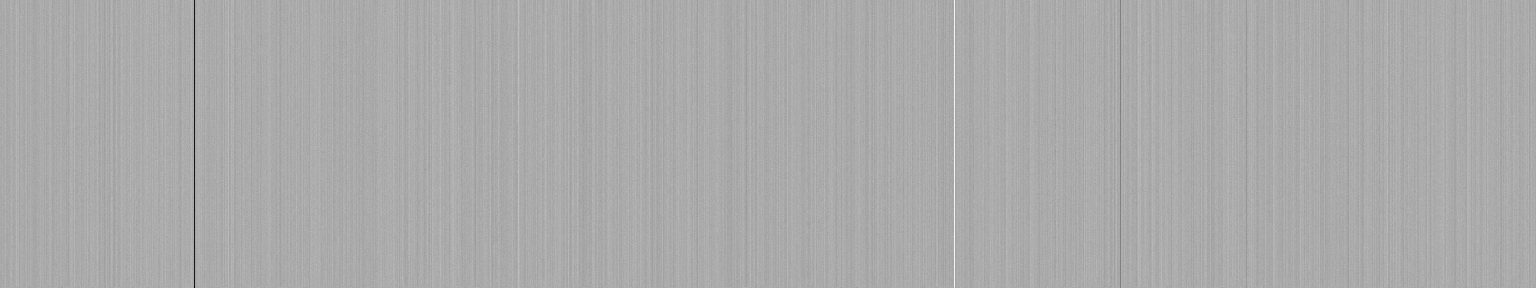

In [6]:
normalized_embeddings = normalization255(embeddings)    # ベクトルを正規化
image = Image.fromarray(normalized_embeddings)   # 行列を画像に変換
image.save(f'{folder_name}/embeddings_monochrome.png')
image

# T-SNEによる次元削減

## ベクトルから画像を生成

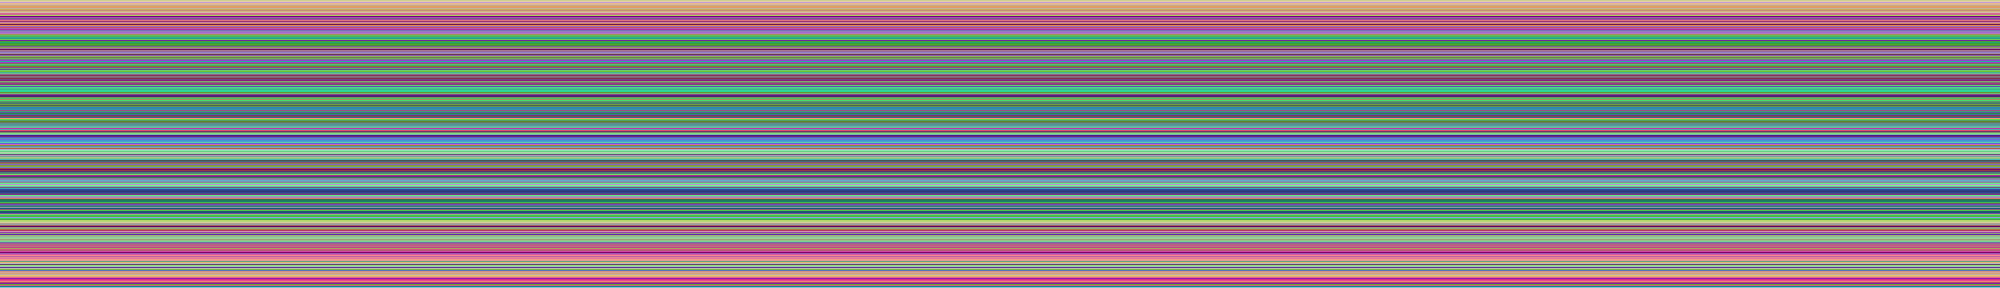

In [7]:
tsne_embeddings = TSNE(n_components=3).fit_transform(embeddings)    # T-SNEで次元削減
normalized_tsne_embeddings = normalization255(tsne_embeddings)   # 次元削減したベクトルを正規化
image_matrix = normalized_tsne_embeddings.reshape((len(normalized_tsne_embeddings), 1, 3))
image_matrix = np.concatenate([image_matrix for _ in range(2000)], 1)
image = Image.fromarray(image_matrix)

# 画像を保存して出力
image.save(f'{folder_name}/embeddings_band_tsne.png')
image

## ベクトルを3次元空間に射影

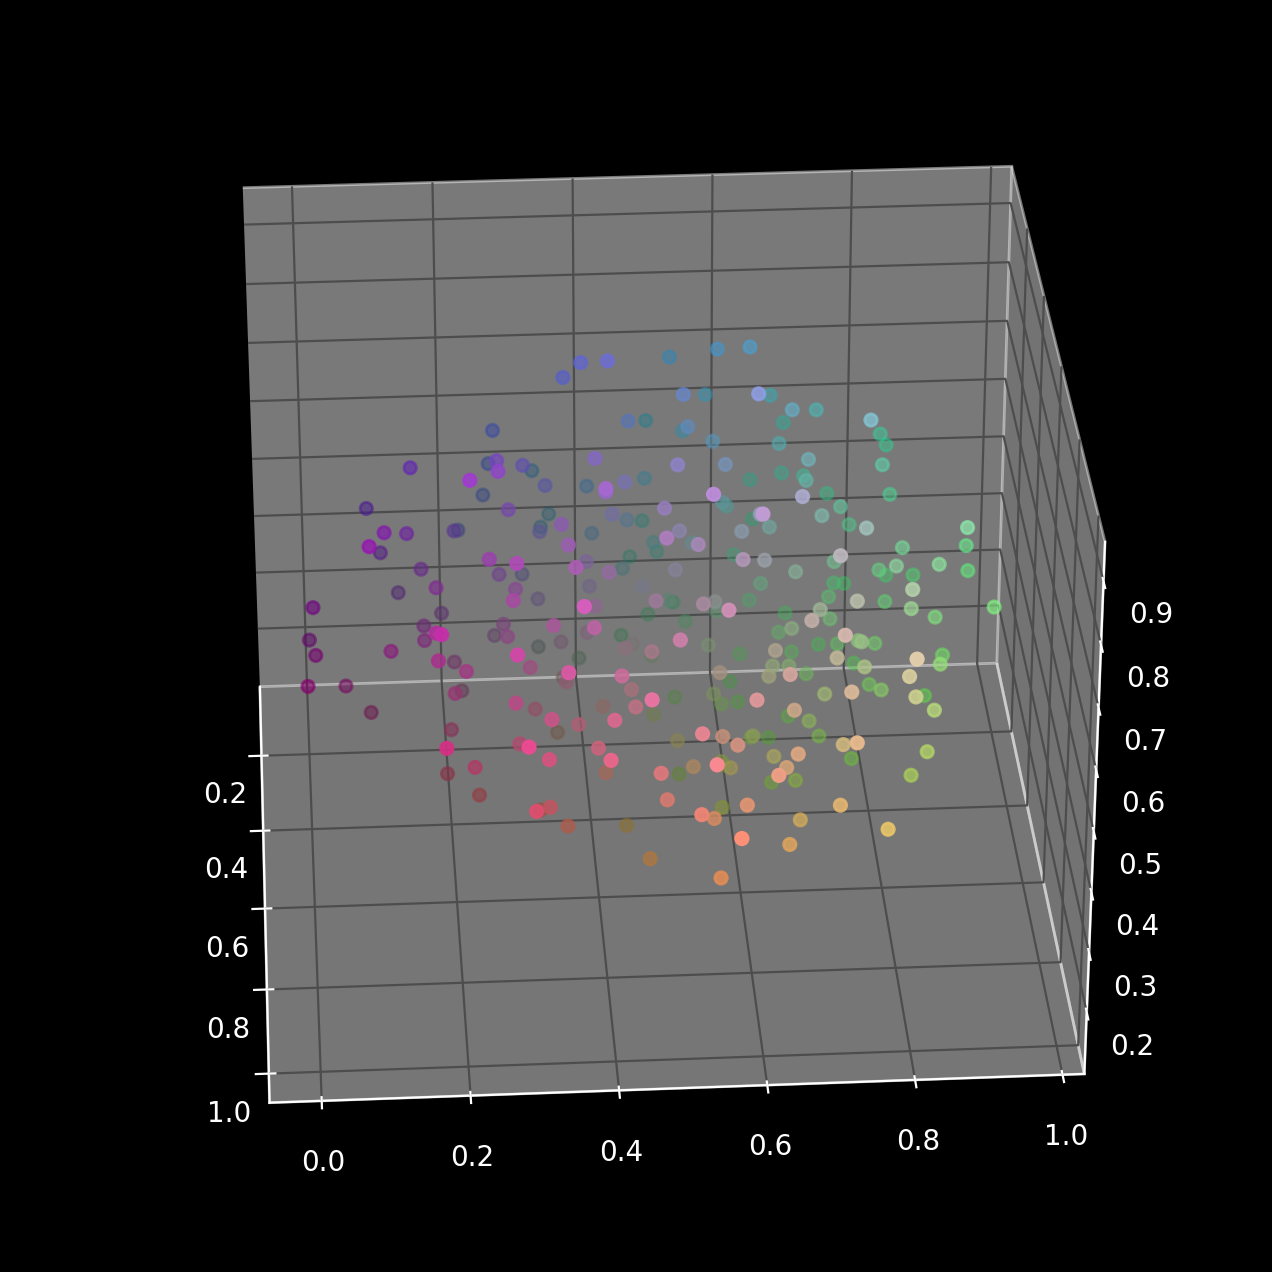

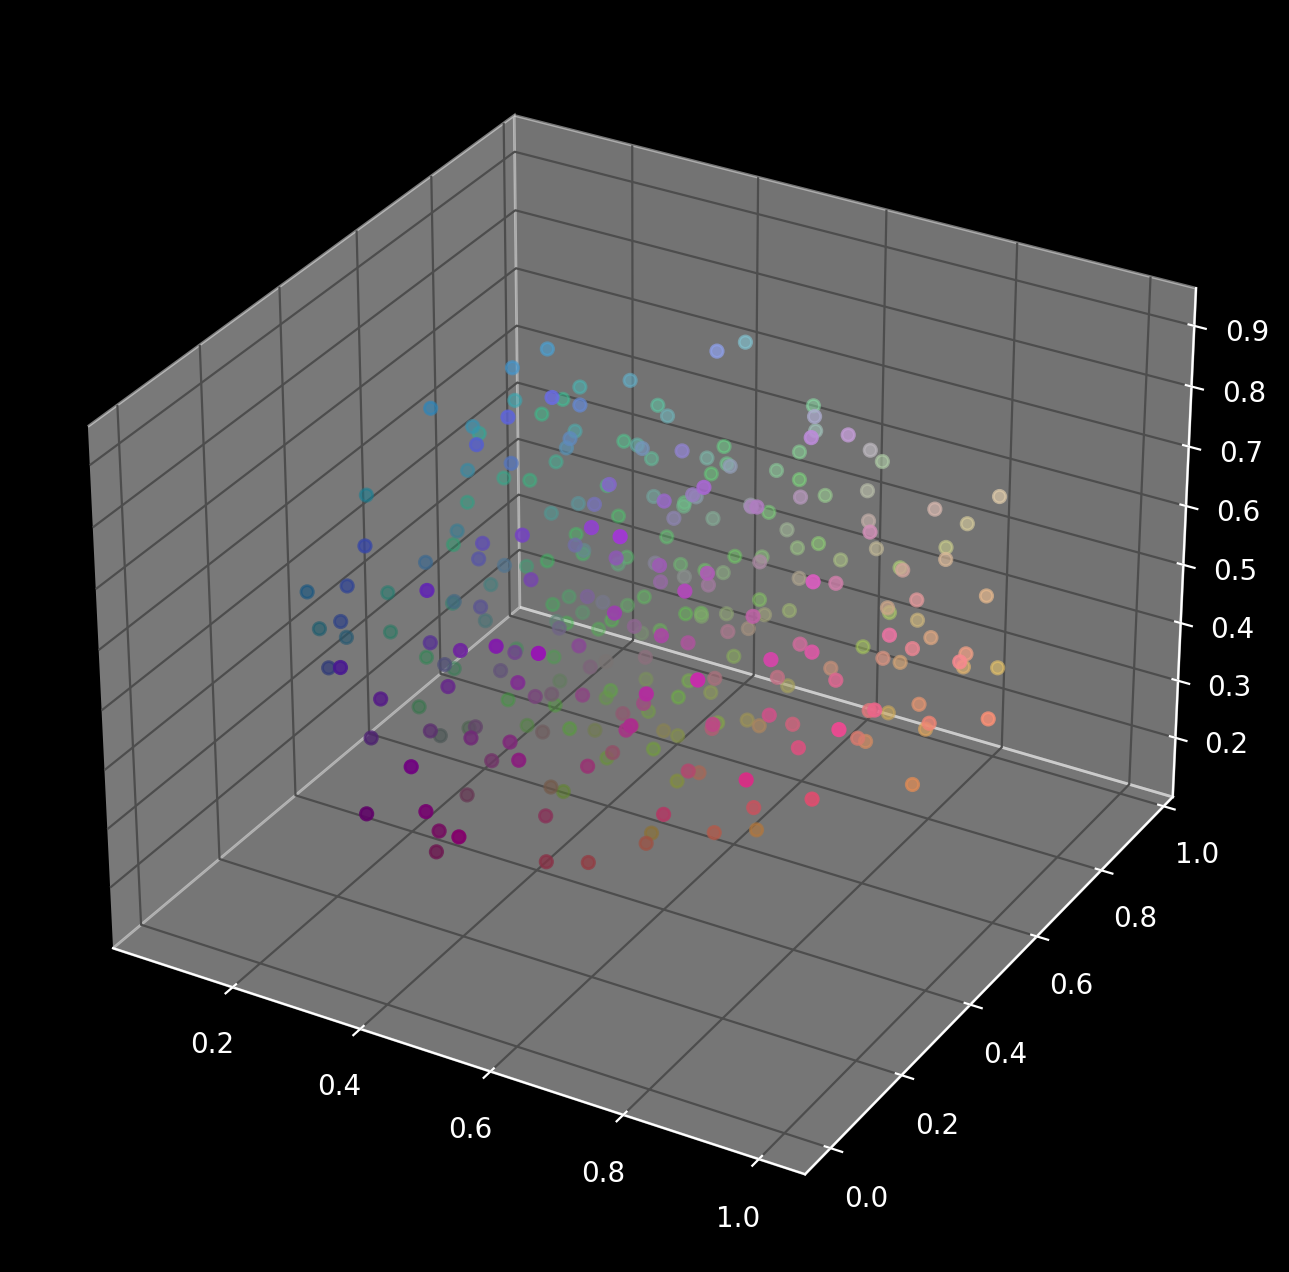

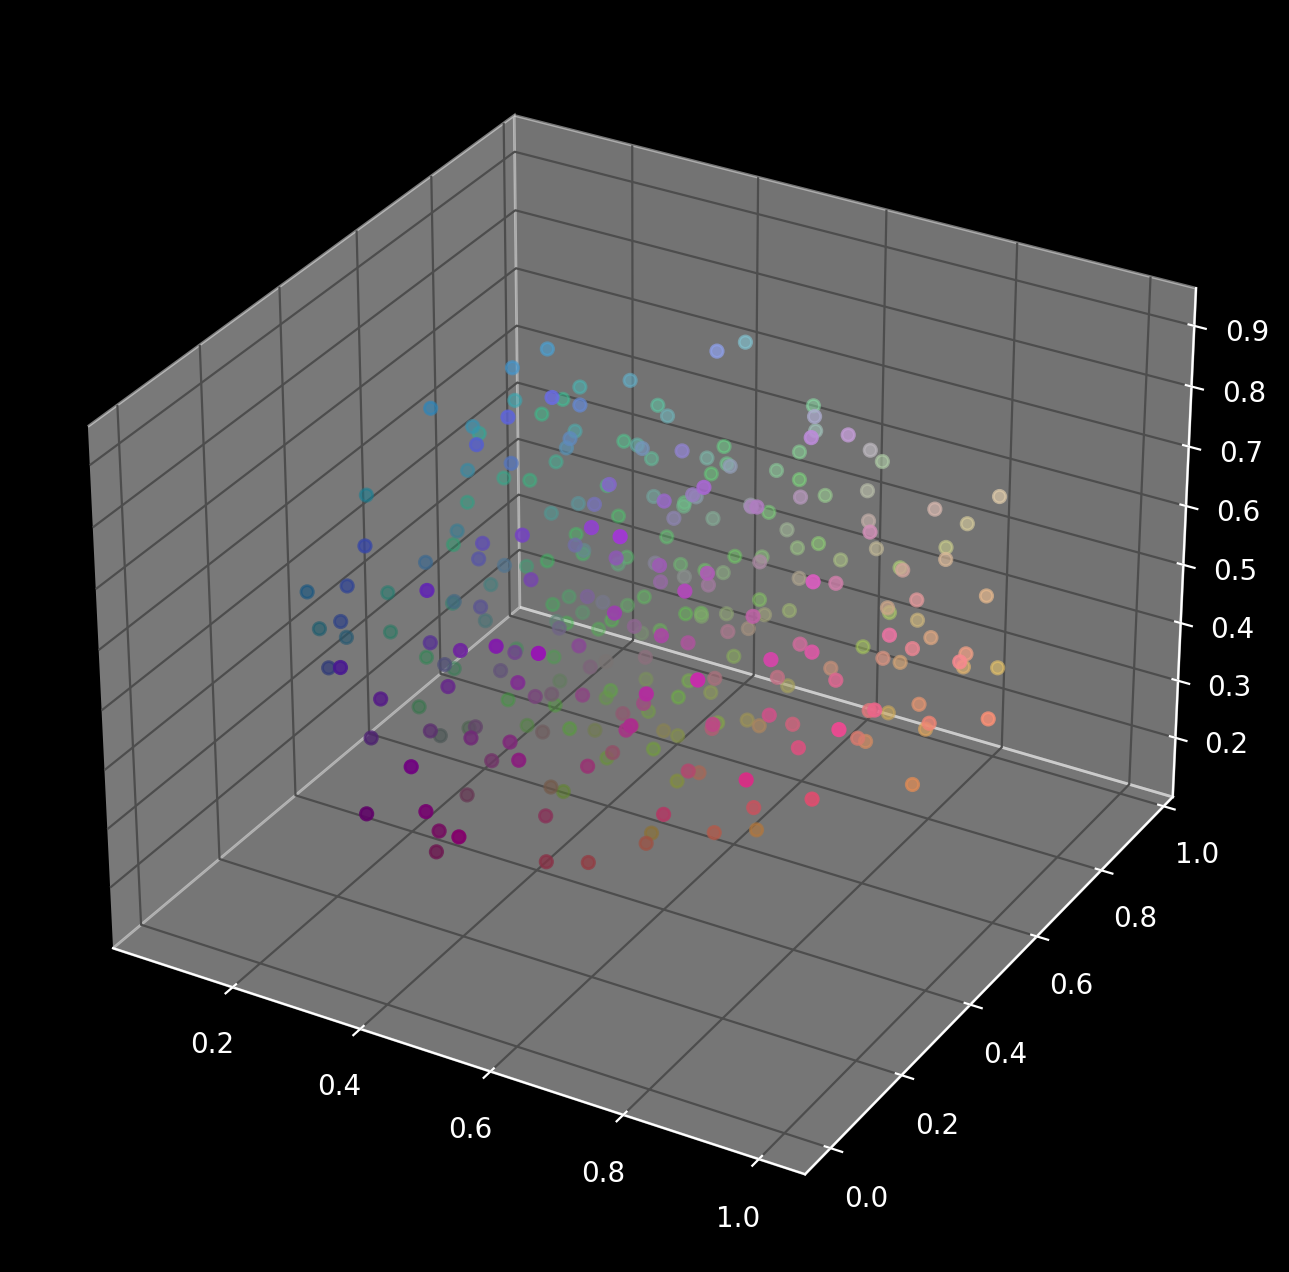

In [8]:
normalized_tsne_embeddings = normalization1(tsne_embeddings)    # 次元削減したベクトルを正規化

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(normalized_tsne_embeddings[:, 0], normalized_tsne_embeddings[:, 1], normalized_tsne_embeddings[:, 2], c=np.column_stack((normalized_tsne_embeddings[:, 0], normalized_tsne_embeddings[:, 1], normalized_tsne_embeddings[:, 2])))

def init():
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(normalized_tsne_embeddings[:, 0], normalized_tsne_embeddings[:, 1], normalized_tsne_embeddings[:, 2], c=np.column_stack((normalized_tsne_embeddings[:, 0], normalized_tsne_embeddings[:, 1], normalized_tsne_embeddings[:, 2])))
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

# アニメーションを作成して保存
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=100, blit=True)
ani.save(f'{folder_name}/rotate_tsne.gif', writer='pillow', dpi=200)

# PCAによる次元削減

## ベクトルから画像を生成

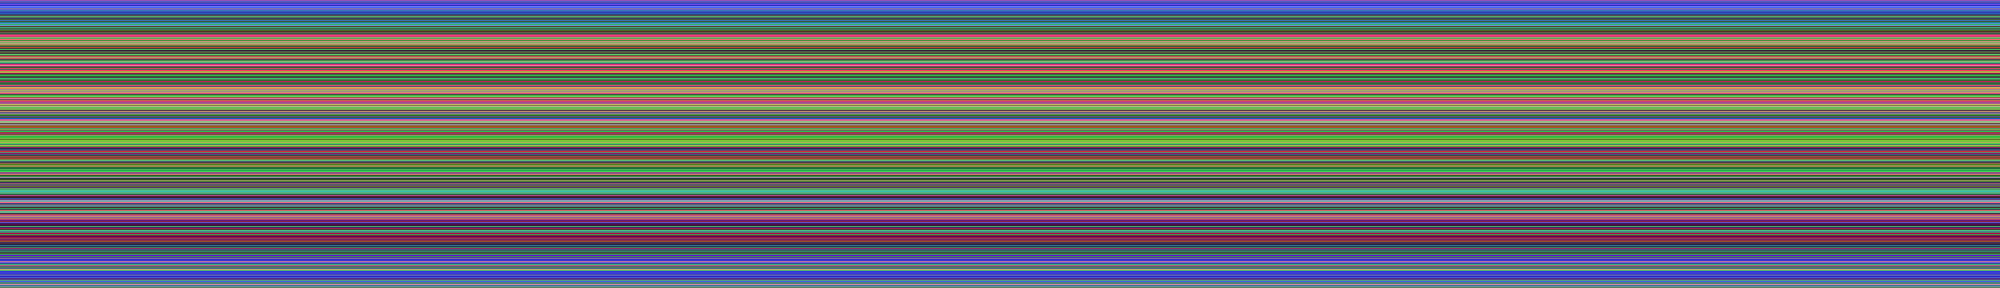

In [9]:
pca_embeddings = PCA(n_components=3).fit_transform(embeddings)  # PCAで次元削減
normalized_pca_embeddings = normalization255(pca_embeddings)   # 次元削減したベクトルを正規化
image_matrix = normalized_pca_embeddings.reshape((len(normalized_pca_embeddings), 1, 3))
image_matrix = np.concatenate([image_matrix for _ in range(2000)], 1)
image = Image.fromarray(image_matrix)

# 画像を保存して出力
image.save(f'{folder_name}/embeddings_band_pca.png')
image

## ベクトルを3次元空間に射影

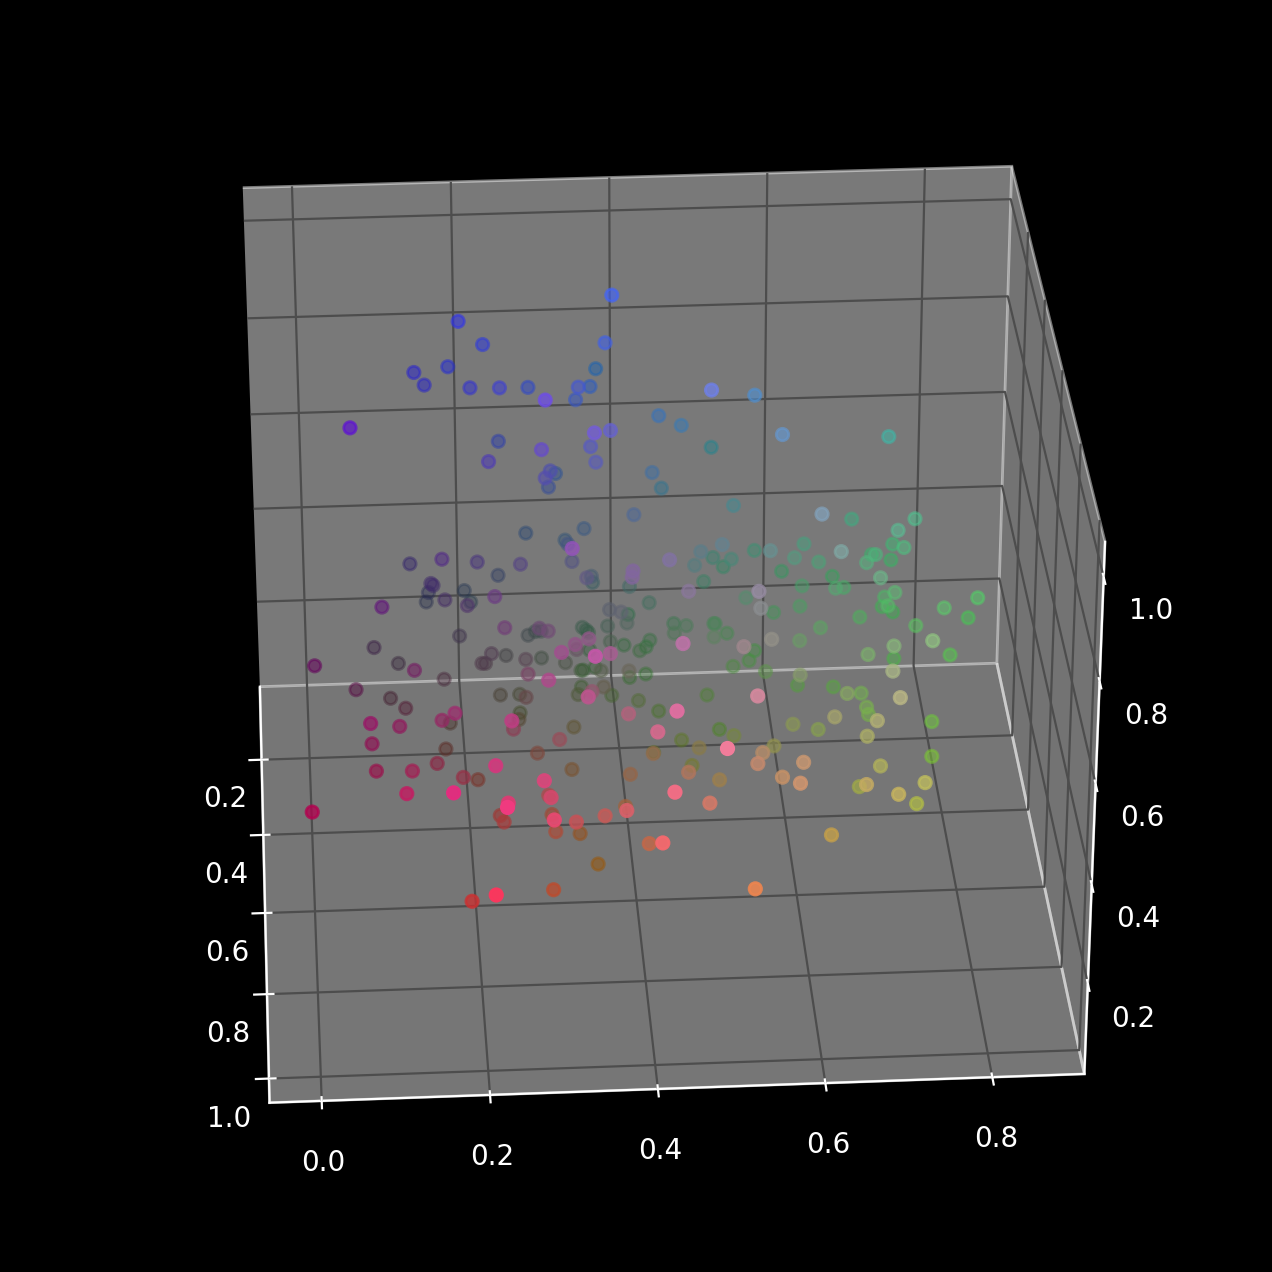

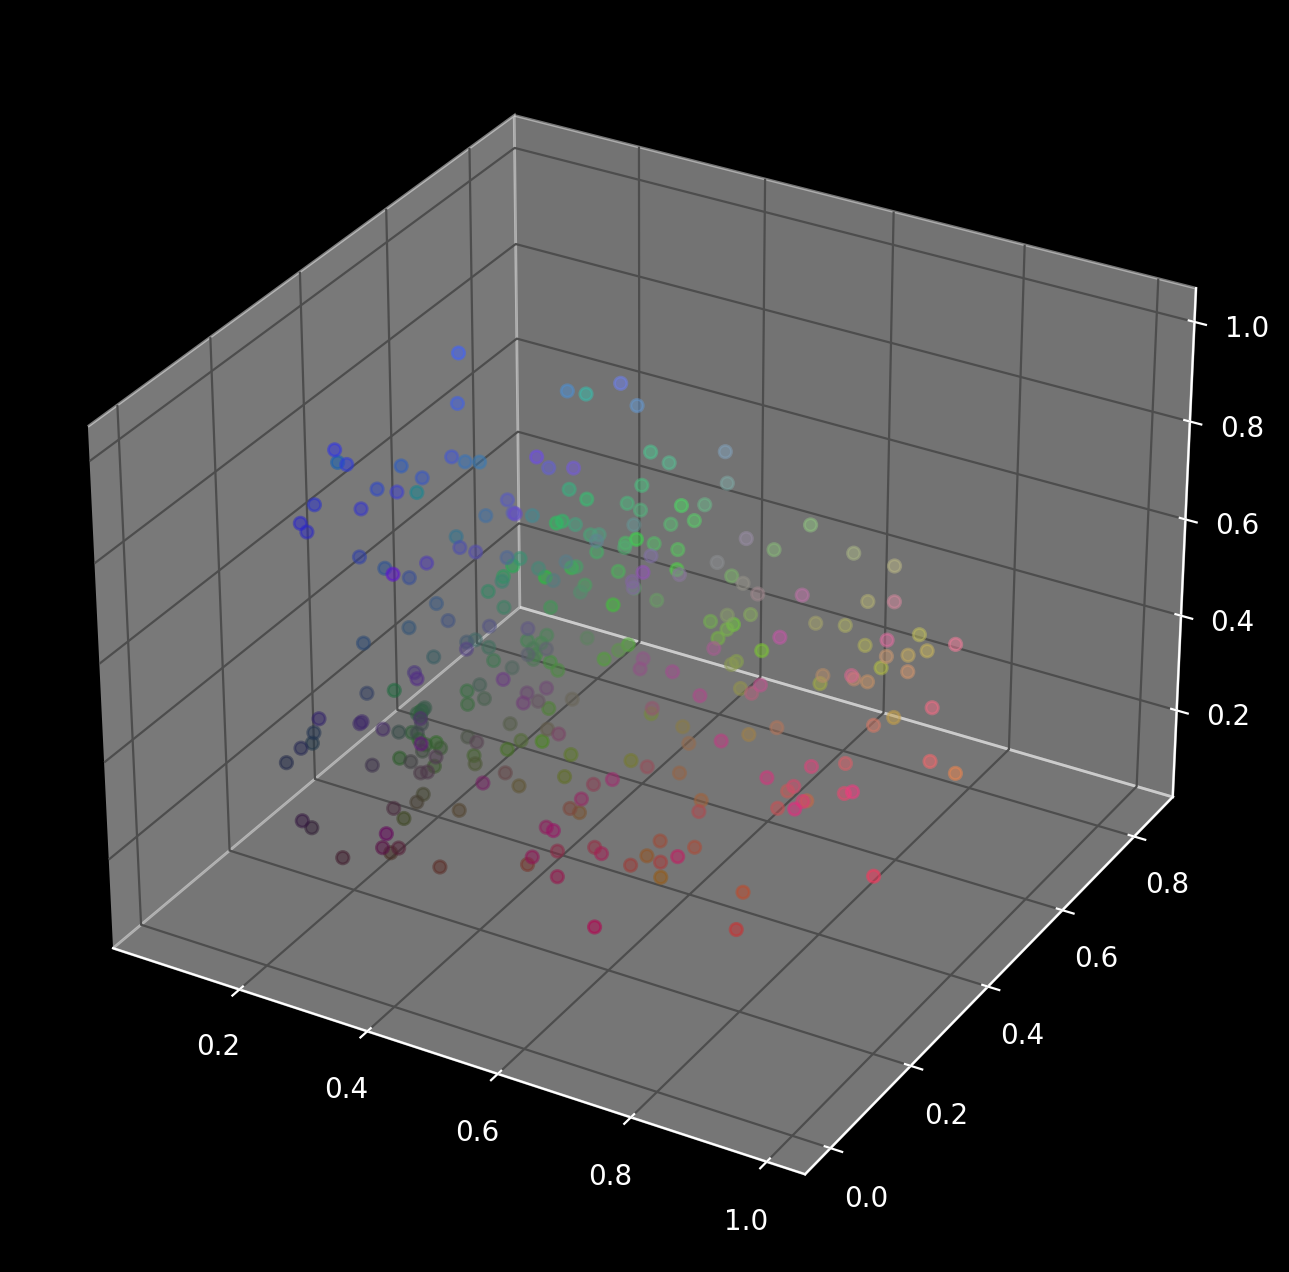

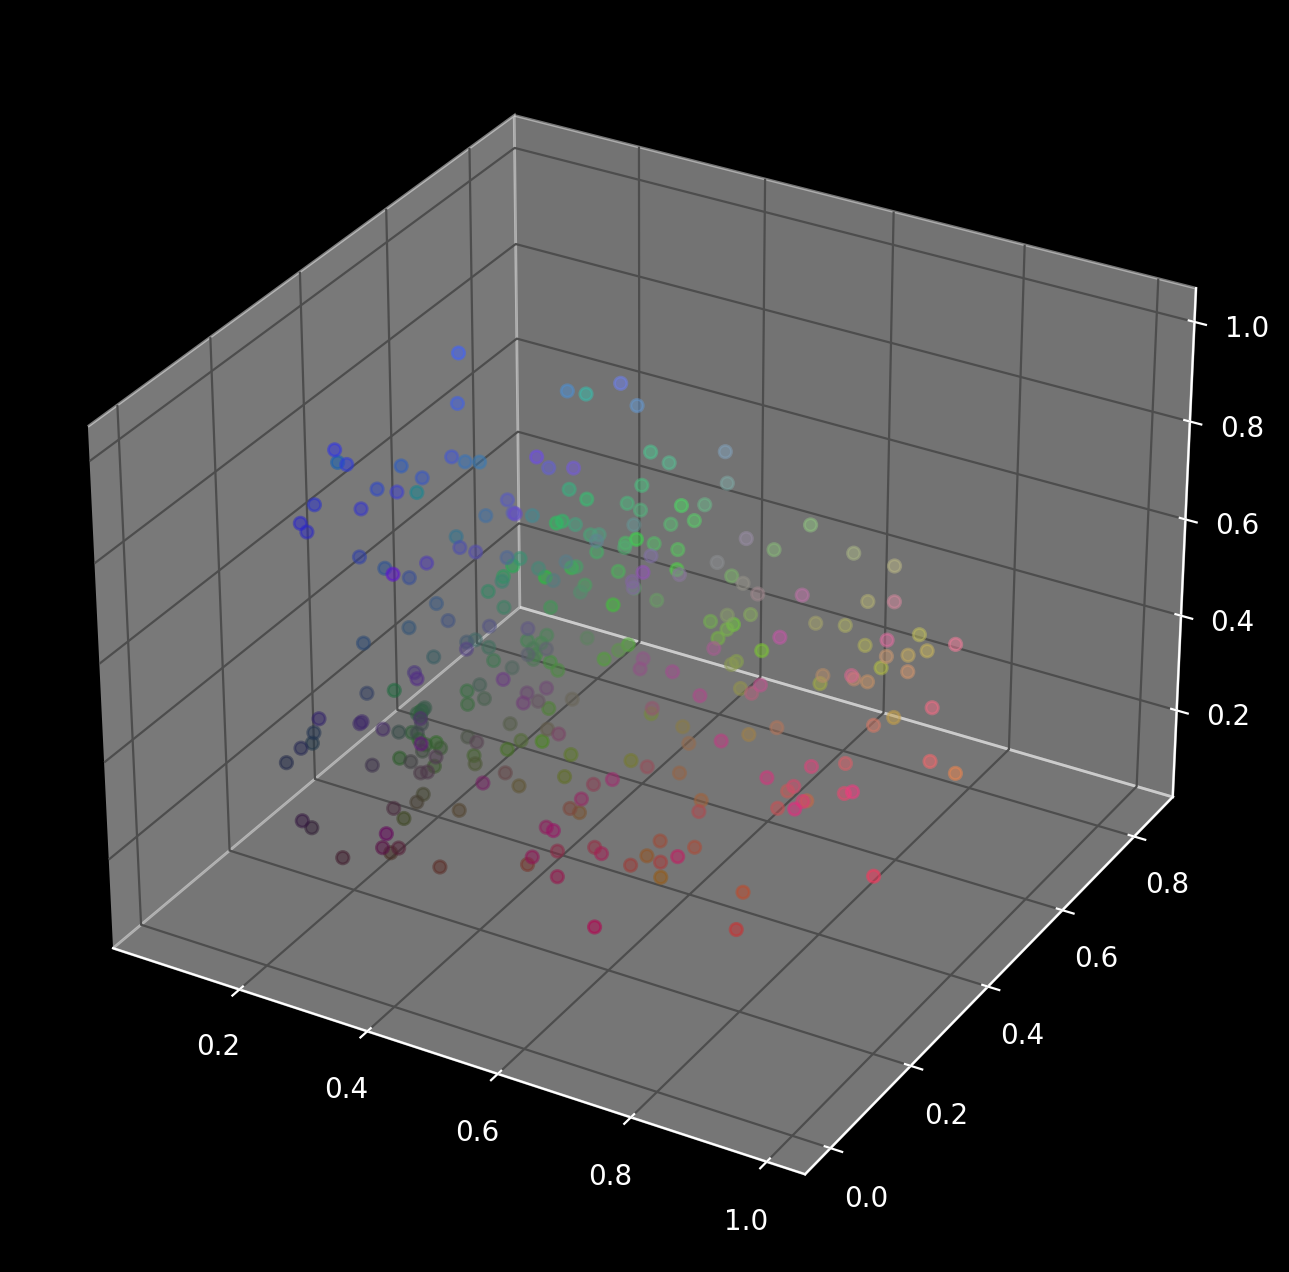

In [10]:
normalized_pca_embeddings = normalization1(pca_embeddings)  # 次元削減したベクトルを正規化

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(normalized_pca_embeddings[:, 0], normalized_pca_embeddings[:, 1], normalized_pca_embeddings[:, 2], c=np.column_stack((normalized_pca_embeddings[:, 0], normalized_pca_embeddings[:, 1], normalized_pca_embeddings[:, 2])))

def init():
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(normalized_pca_embeddings[:, 0], normalized_pca_embeddings[:, 1], normalized_pca_embeddings[:, 2], c=np.column_stack((normalized_pca_embeddings[:, 0], normalized_pca_embeddings[:, 1], normalized_pca_embeddings[:, 2])), alpha=0.5)
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

# アニメーションを作成して保存
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=100, blit=True)
ani.save(f'{folder_name}/rotate_pca.gif', writer='pillow', dpi=200)